# Prompt Optimisation

As your system built on AgentX goes to production, whether it is using the Agent class or publishing Tool to the store, you will accumulate more and more feedback data. Utilising these data, you can tune the prompt and the inference hyperparameters to achieve elevated performance.

This notebook demonstrate how to tune prompt and the inference hyperparameters to better predict the salary range of a job posting based on its job description, which can be used to help job seekers and hiring managers to better understand the job market.

In [1]:
# Data sourced from https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
# CC BY-SA 4.0 license
# Data cleaned and filtered by Chan Ka Hei
import json
from pandas import read_parquet
from rich import print as rich_print

dataset = read_parquet(
    'data/job_posting_2023.parquet'
)

dataset.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,salary,short_description,skill_set
20487,3701151544,20122211.0,Senior Litigation Attorney/Special Assistant A...,SENIOR LITIGATION ATTORNEY/SPECIAL ASSISTANT A...,128252.0,NaN,111251.0,YEARLY,Full-time,"Providence, RI",...,1.692730e+12,None,1,FULL_TIME,USD,BASE_SALARY,1,119751.5,The Rhode Island Office of the Attorney Genera...,"[""Trial experience"", ""Supervisory experience"",..."
25611,3697340789,90639.0,Site Civil Engineer,Green Key is looking for a strong site design ...,120000.0,NaN,100000.0,YEARLY,Full-time,"New York, NY",...,1.692730e+12,None,1,FULL_TIME,USD,BASE_SALARY,1,110000.0,Green Key is seeking a Civil Engineer with exp...,"[""Autocad"", ""Civil 3D"", ""Stormwater management..."
22215,3699085089,1441.0,"Software Engineering Manager II, Google Cloud ...",Note: By applying to this position you will ha...,283000.0,NaN,185000.0,YEARLY,Full-time,"Seattle, WA",...,1.692830e+12,careers.google.com,1,FULL_TIME,USD,BASE_SALARY,1,234000.0,"Like Google's own ambitions, the work of a Sof...","[""Bachelor\u2019s degree or equivalent practic..."
821,3757776363,2908367.0,Licensed Journeyman Electician,Gpac just partnered with a super company to fi...,100000.0,NaN,70000.0,YEARLY,Full-time,"San Diego, CA",...,1.699070e+12,usa.applybe.com,0,FULL_TIME,USD,BASE_SALARY,1699138477,85000.0,Gpac has partnered with a company to find Sola...,"[""Journeyman Electrician license"", ""At least 3..."
7506,3757446699,8052981.0,Senior Buyer,"ObjectiveBroadband Telecom Power, an EV chargi...",90000.0,NaN,80000.0,YEARLY,Full-time,"Santa Ana, CA",...,1.699040e+12,None,0,FULL_TIME,USD,BASE_SALARY,1699039150,85000.0,"Broadband Telecom Power, an EV charging equipm...","[""Bachelor's Degree in Business, Engineering o..."


In [2]:
# We will use 'salary' as our target variable.
# We will use 'title', 'short_description', 'skill_set', 'location', 'formatted_experience_level' as our input variable.

# Remove curreny other than USD
dataset.skill_set = dataset.skill_set.apply(lambda x: json.loads(x))
x = dataset[
    [
        'title', 
        'short_description',
        'skill_set',
        'location',
        'formatted_experience_level', 
    ]
].to_dict(orient='records')


y = dataset['salary'].to_list()

# Split the dataset into training and testing set
from random import sample

test_ids = sample(range(len(x)), 50)
x_train = [x[i] for i in range(len(x)) if i not in test_ids]
x_test = [x[i] for i in range(len(x)) if i in test_ids]
y_train = [y[i] for i in range(len(y)) if i not in test_ids]
y_test = [y[i] for i in range(len(y)) if i in test_ids]

In [3]:
# Use AgentX to generate a model that can predict salary based on job title, description, location, and experience level.
# This will be the baseline of the optimisation process.

from agentx.agent import Agent
from agentx.schema import GenerationConfig, Message, Content
from dotenv import load_dotenv
from typing import List, Union
from pydantic import BaseModel
import os
import asyncio

load_dotenv()

# model the input
class JobPost(BaseModel):
    title: str
    short_description: str
    skill_set: List[str]
    location: Union[str, None]
    formatted_experience_level: Union[str, None]

# model the output
class SalaryPrediction(BaseModel):
    reasons: str
    salary: int

class TrueSalary(BaseModel):
    salary: int

# let's use mistralai/Mixtral-8x7B-Instruct-v0.1 for lower cost
generation_config = GenerationConfig(
    api_type='openai',
    api_key=os.environ.get('ANYSCALE_API_KEY'),
    base_url=os.environ.get('ANYSCALE_OPENAI_ENDPOINT'),
    model='mistralai/Mixtral-8x7B-Instruct-v0.1',
)

# AZURE API for reference
#generation_config = GenerationConfig(
#    api_type='openai',
#    api_key=os.environ.get('AZURE_API_KEY'),
#    base_url=os.environ.get('AZURE_OPENAI_ENDPOINT'),
#    azure_deployment='gpt-35',
#)

# define the agent that perform the prediction. The system prompt will the optimisation target.
salary_prediction_agent = Agent(
    name='salary_prediction',
    generation_config=generation_config,
    system_prompt='''You will predict the salary of a job posting based on the job title, description, location, and experience level.
Output JSON format only.''',
)

In [4]:
async def forward(agent:Agent, input:JobPost) -> Union[SalaryPrediction, None]:
    response = await agent.a_generate_response(
        messages=[
            Message(
                role='user',
                content=Content(
                    text=input.model_dump_json(),
                )
            )
        ],
        output_model=SalaryPrediction,
    )
    return SalaryPrediction.model_validate_json(response[0].content.text) if response else None

In [5]:
# perform one prediction for sanity check

test_predict = await forward(
    salary_prediction_agent,
    input = JobPost(**x_test[0])
)

rich_print(
    test_predict
)

rich_print(
    {
        'Actual Salary': TrueSalary(salary=y_test[0]),
    }
)

SalaryPrediction(
    reasons='Based on the job title, a Licensed Journeyman Electrician can earn an average salary in the range of 
$50,000 to $70,000 per year. The location, San Diego, CA, is known for having a higher cost of living, which can 
result in a salary towards the higher end of the range. The requirement of at least 3 years of residential and/or 
commercial solar experience, as well as experience with low to medium voltage underground work and power 
distribution, can also lead to a higher salary. Additionally, the company may offer a higher salary due to the need
for NABCEP certification and the necessity of working with the Electrical Engineering team. However, as this is an 
entry-level position, the salary may start towards the lower end of the range until the candidate gains more 
experience and skills on the job',
    salary=60000
)

{'Actual Salary': TrueSalary(salary=85000)}

In [19]:
# test the agent with the test set to get a baseline performance

from tqdm import tqdm

predict:List[Union[SalaryPrediction, None]] = []

batch_size = 5
# perform prediction for the test set
for index in tqdm(range(0,50,batch_size)):
    batch = await asyncio.gather(*[
        forward(salary_prediction_agent, JobPost(**x_test[i])) for i in range(index, index+batch_size)
    ])
    predict.extend(batch)
    # avoid rate limiting error
    await asyncio.sleep(5)

100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


In [5]:
# Let's check how well the agent did

def loss(predicted:Union[SalaryPrediction, None], truth:TrueSalary) -> float:
    if not predicted:
        return None

    l2 = (predicted.salary - truth.salary)**2
    return l2

In [ ]:
from statistics import mean

rmse = mean([
    loss(
        predict,
        TrueSalary(salary=y)
    ) for predict, y in zip(predict, y_test) if predict != None
])**0.5

rich_print('Root mean square error: ±{rmse} USD'.format(rmse=rmse))
rich_print('Average salary range in the dataset: ±{avg} USD'.format(avg=np.mean(np.subtract(dataset.max_salary,dataset.min_salary))/2))

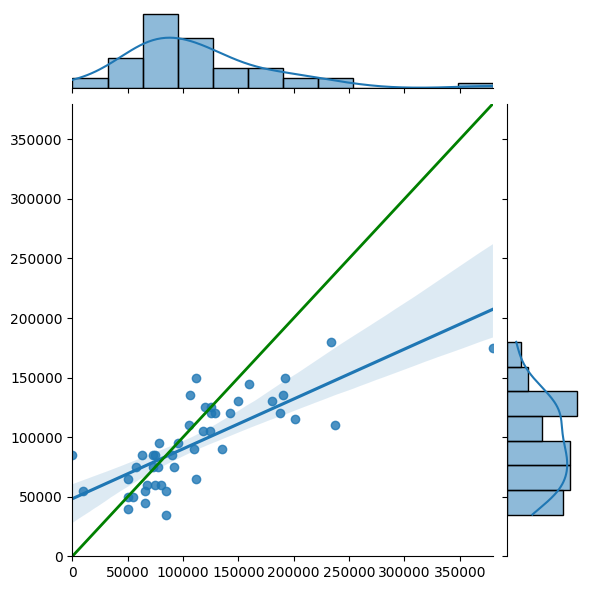

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

drop_na = [(p, a) for p, a in zip(predict, y_test) if p != None]
predicted = [d[0].salary for d in drop_na]
truth = [d[1] for d in drop_na]

# plot the predicted vs actual salary
sns.jointplot(
    x=truth,
    y=predicted,
    kind='reg',
    xlim=(0, max(truth)),
    ylim=(0, max(truth)),
)

# the ideal prediction line
plt.plot([0, max(truth)], [0, max(truth)], linewidth=2, color='g')

Obviously the room for improvement is huge. GPT is systematically underestimating the salary of a job paying over 75K USD. Let's get started to optimise the prediction!

In [7]:
import pickle

with open('saved_prediction.pkl', 'rb') as f:
    responses = pickle.load(f)

In [6]:
from agentx.optimisers import TextualGradientPromptTrainer

trainer = TextualGradientPromptTrainer(
    agent=salary_prediction_agent,
    generation_config=generation_config,
    forward=forward,
    loss=loss,
    n_beam=4,
    n_sample=10,
    budget=50
)

In [7]:
result = await trainer.fit(
    x=x_train,
    y=y_train,
    n_training_steps=5,
)

TypeError: cannot pickle '_thread.RLock' object

In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler